# Quick Start

The notebook contains basic usage examples of NNDE. Also, running the whole notebook produces the figures included in the paper. 

## Installation

In [1]:
try:
    import NNDE
except:
    ! pip install -r requirements.txt
    ! pip install git+https://github.com/Karlmyh/NNDE.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Sampling Tools

In [3]:
###### generate samples with marginal density (Exp(0.5),Exp(0.5),Uniform(0,5))

from NNDE import ExponentialDistribution, UniformDistribution, MarginalDistribution

# setup
dim=3
density1 = ExponentialDistribution(lamda=0.5) 
density2 = UniformDistribution(low=0,upper=5) 

density_seq=[]
for i in range(dim-1):
    density_seq = density_seq+[density1]
density_seq=density_seq+[density2]

densitymarginal = MarginalDistribution(density_seq)


# generate 10 samples and return their pdf
samples,samples_pdf = densitymarginal.generate(10)
samples

array([[0.42217457, 0.07151545, 0.37850096],
       [0.13709695, 0.50490829, 1.35081244],
       [0.886786  , 0.55069555, 0.77787855],
       [0.13086774, 0.08518076, 4.48993547],
       [0.8704253 , 0.84518152, 1.32339602],
       [0.19701885, 0.00728319, 4.44601087],
       [0.37967175, 0.43093558, 0.6673608 ],
       [0.82918907, 0.05550985, 3.66128261],
       [0.03037561, 0.43095105, 1.25361253],
       [0.19623446, 0.00825805, 4.17675687]])

In [4]:
# evaluate pdf at given samples
densitymarginal.density(samples)

# compare with true pdf
samples_pdf



array([0.29804118, 0.22153958, 0.04513458, 0.51931712, 0.02587813,
       0.53166184, 0.15812677, 0.13634847, 0.31797043, 0.53145934])

array([0.29804118, 0.22153958, 0.04513458, 0.51931712, 0.02587813,
       0.53166184, 0.15812677, 0.13634847, 0.31797043, 0.53145934])

In [5]:
###### generate samples with mixture density 0.4*Normal(1.5,0.05)+0.6*Normal(-1.5,0.3)

from NNDE import MultivariateNormalDistribution, MixedDistribution

# setup
dim=2
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.05)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.3)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)

# generate 10 samples and return their pdf
samples, samples_pdf = densitymix.generate(10)
samples

array([[-2.23087816, -1.08521314],
       [-1.03424594, -1.24327987],
       [-2.02698363, -1.63201056],
       [ 1.43021832,  1.51448518],
       [ 1.58820377,  1.8541296 ],
       [-0.88802267, -2.398429  ],
       [-1.26067249, -2.12988644],
       [-1.92476226, -2.0167295 ],
       [-2.0035588 , -1.35662414],
       [-1.46406062, -1.9693262 ]])

In [6]:
# evaluate pdf at given samples
densitymix.density(samples)

# compare with true pdf
samples_pdf



array([0.09809866, 0.1986687 , 0.19463535, 1.21018283, 0.3361115 ,
       0.04441337, 0.14935128, 0.15100377, 0.20157171, 0.22002933])

array([0.09809866, 0.1986687 , 0.19463535, 1.21018283, 0.3361115 ,
       0.04441337, 0.14935128, 0.15100377, 0.20157171, 0.22002933])

## Adaptive KD Tree

The Adaptive KD Tree is able to select largest k such that $R_k^{\beta}*k<C$ for given $\beta$ and $C$.

In [ ]:
###### normal KDTree query as in sklearn

from NNDE import KDTree as AKDTree
X_train, _=densitymix.generate(1000)
X_test, _=densitymix.generate(4)


tree = AKDTree(X_train, leaf_size=2)              
dist, ind = tree.query(X_test, k=3)  

dist
ind

In [ ]:
###### adaptive KDTree query 
    
dist, k = tree.adaptive_query(X_test, C=1, beta=1)  

# dist**beta * k should be close to but smaller than C=0.1 for all entries
dist*k

## NN Density Estimators

In [7]:
###### using AWNN to estimate density

from NNDE import AWNN

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)
X_test, pdf_X_test =densitymix.generate(1000)

# choose parameter C=0.1
model_AWNN=AWNN(C=.1).fit(X_train)
# output is log scaled
est_AWNN=np.exp(model_AWNN.predict(X_test))
# compute the mean absolute error
np.abs(est_AWNN-pdf_X_test).mean()


0.09148487940943466

In [8]:
###### using KNN to estimate density with k chosen by cross validation with respect to MISE criterion

from NNDE import KNN
from sklearn.model_selection import GridSearchCV

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)
X_test, pdf_X_test =densitymix.generate(1000)

# select parameter grid
parameters={"k":[int(i*1000) for i in [0.01,0.02,0.05,0.1,0.2,0.5]]}
# use all available cpu, use 10 fold cross validation
cv_model_KNN=GridSearchCV(estimator=KNN(),param_grid=parameters,n_jobs=-1,cv=10)
_=cv_model_KNN.fit(X_train)
model_KNN=cv_model_KNN.best_estimator_
    
# output is log scaled
est_KNN=np.exp(model_KNN.predict(X_test))
# compute the mean absolute error
np.abs(est_KNN-pdf_X_test).mean()


0.055937476261628344

## Visualization

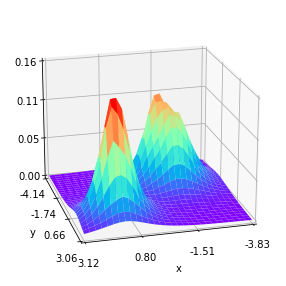

In [11]:
###### 3d prediction surface using WKNN

from NNDE import contour3d
from sklearn.model_selection import GridSearchCV

# generate samples
dim=2
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=contour3d(X_train,method="WKNN",k=100)
model_plot.estimation()
fig=model_plot.make_plot()

fig.savefig("../paper/readme_example_1.pdf",bbox_inches="tight",dpi=600)

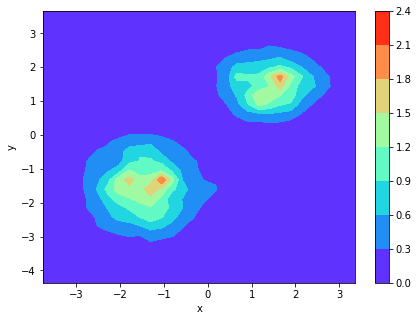

In [12]:
###### 2d prediction surface using BKNN

from NNDE import contour2d
from sklearn.model_selection import GridSearchCV

# generate samples
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=contour2d(X_train,method="BKNN",C=10)
model_plot.estimation()
fig=model_plot.make_plot()

fig.savefig("../paper/readme_example_2.pdf",bbox_inches="tight",dpi=600)


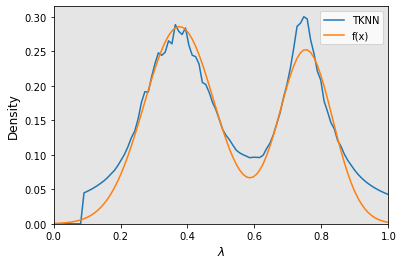

In [14]:
###### 1d prediction line plot using TKNN

from NNDE import lineplot
from sklearn.model_selection import GridSearchCV

# generate samples
dim=1
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)



model_plot=lineplot(X_train,method_seq=["TKNN"],true_density_obj=densitymix,kargs_seq=[{"k":150}])
fig=model_plot.plot()

fig.savefig("../paper/readme_example_3.pdf",bbox_inches="tight",dpi=600)

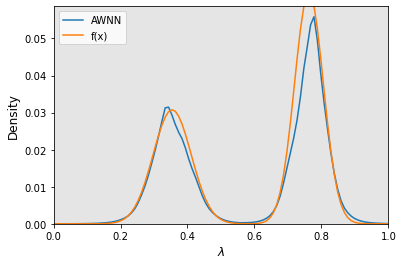

In [15]:
###### high dimensional sliced prediction line plot using AWNN
###### slicing is done


# generate samples
dim=4
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)
X_train, pdf_X_train =densitymix.generate(1000)

model_plot=lineplot(X_train,method_seq=["AWNN"],true_density_obj=densitymix,kargs_seq=[{"C":0.5}])
fig=model_plot.plot()



TypeError: bknn() missing 1 required positional argument: 'C2'

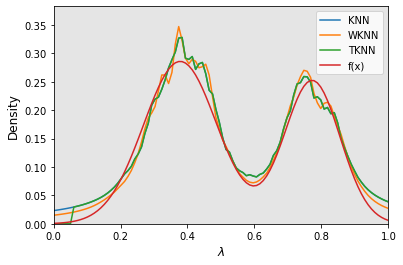

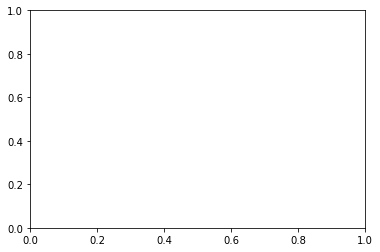

In [16]:
###### plot in the paper 

# generate samples
dim=1
np.random.seed(666)
density1 = MultivariateNormalDistribution(mean = np.zeros(dim)+1.5, cov = np.diag(np.ones(dim)*0.4)) 
density2 = MultivariateNormalDistribution(mean = np.zeros(dim)-1.5, cov = np.diag(np.ones(dim)*0.7)) 
density_seq = [density1, density2]
prob_seq = [0.4, 0.6]
densitymix = MixedDistribution(density_seq, prob_seq)
X_train, pdf_X_train =densitymix.generate(1000)


kargs_seq= [{"k":100},{"k":100},{"k":100} ]
model_plot=lineplot(X_train,method_seq=["KNN", "WKNN", "TKNN"],true_density_obj=densitymix,kargs_seq=kargs_seq)
fig=model_plot.plot()
fig.savefig("../paper/example_1.pdf",bbox_inches="tight",dpi=600)

kargs_seq= [{"C":0.9},{"C":1},{"C":1} ]
model_plot=lineplot(X_train,method_seq=["AKNN", "BKNN", "AWNN"],true_density_obj=densitymix,kargs_seq=kargs_seq)
fig=model_plot.plot()
fig.savefig("../paper/example_2.pdf",bbox_inches="tight",dpi=600)

